This is a traffic prediction application that uses Machine Learning, and Time Series Analysis to predict the traffic 
flow at four different location. 

The chosen locations are limited by the data source, the application can, however, be used to predict the traffic 
flow on different traffic features: roads, junctions, by passes, service lanes and so on. 

Time series analysis is used to determine traffic trends over different periods; years, months, days, and hours. These data features are then transformed and used to train a tensor flow GRU model, that predicts the likelihood of traffic snarl up in four different locations, based on historical data. 

In [ ]:
"""
In this section:
Import libraries relevant to the project.
"""
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import math

from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow
from keras import callbacks
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

import warnings
warnings.filterwarnings("ignore")

In [ ]:
"""
In this section:
Load the dataset and check data status
"""
df = pd.read_csv('/content/sample_data/traffic.csv')

df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [ ]:
"""
In this section:
parsing dates
"""
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [ ]:
"""
In this section:
delete uncessary column(s)
"""
df = df.drop(['ID'], axis=1)

df.head()

,DateTime,Junction,Vehicles
0,2015-11-01 00:00:00,1,15
1,2015-11-01 01:00:00,1,13
2,2015-11-01 02:00:00,1,10
3,2015-11-01 03:00:00,1,7
4,2015-11-01 04:00:00,1,9


In [ ]:
data = df.copy()

In [ ]:
"""
In this section:
Perform Exploratory Data Analysis
 - Check data features
 - Check data distribution
 - Check data relevance
"""

Text(0.5, 0, 'Date')

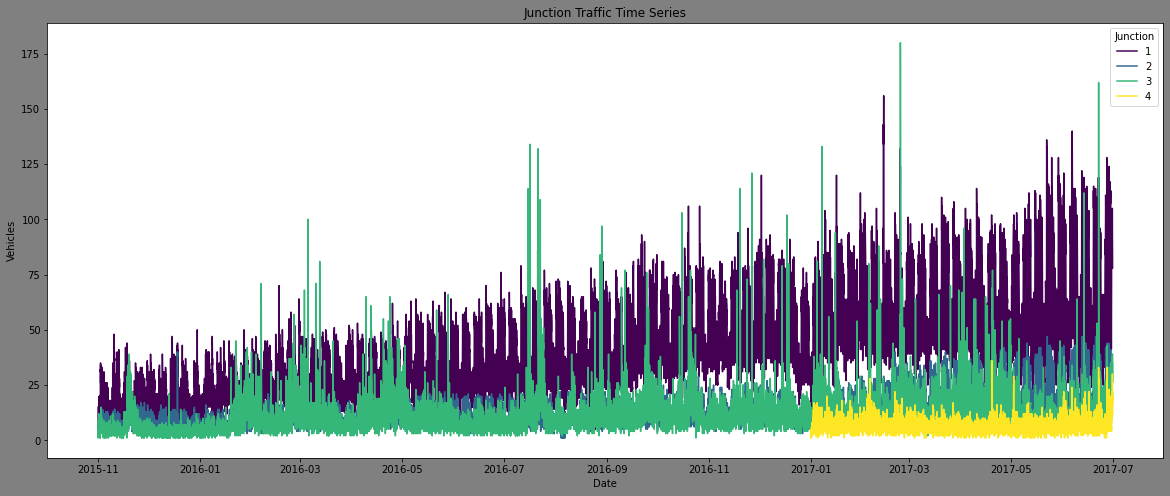

In [ ]:
plt.figure(figsize=(20,8), facecolor="#808080")
 
t_series = sns.lineplot(x=data['DateTime'], y='Vehicles', data=data, hue='Junction', palette='viridis')
t_series.set_title('Junction Traffic Time Series')
t_series.set_ylabel('Vehicles')
t_series.set_xlabel('Date')

FEATURE ENGINEERING

In [ ]:
"""
In this section:
Create new features from the dataset
 - Year, Month, Date, Hour & Day; to be used for Time series analysis
"""

data['Year'] = data['DateTime'].dt.year
data['Month'] = data['DateTime'].dt.month
data['Date'] = data['DateTime'].dt.day
data['Hour'] = data['DateTime'].dt.hour
data['Day'] = data.DateTime.dt.strftime("%A")

data.head()

,DateTime,Junction,Vehicles,Year,Month,Date,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


EDA

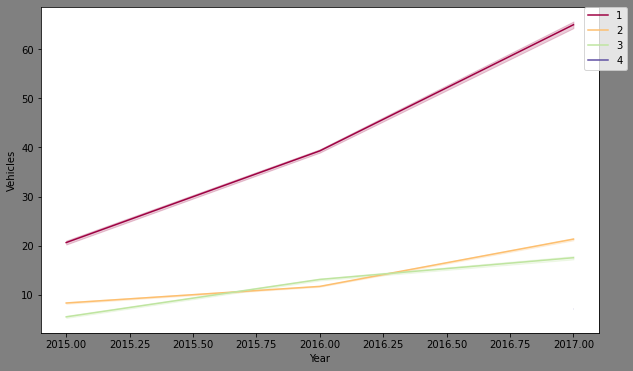

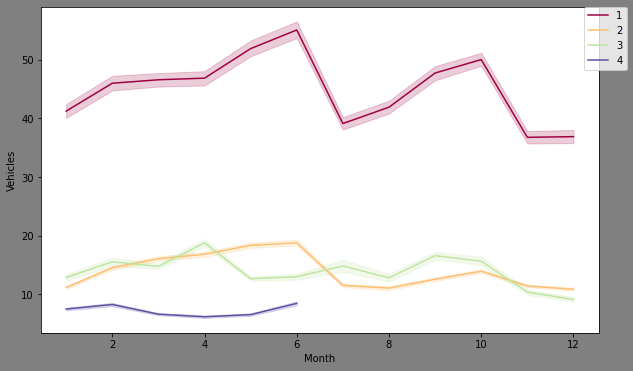

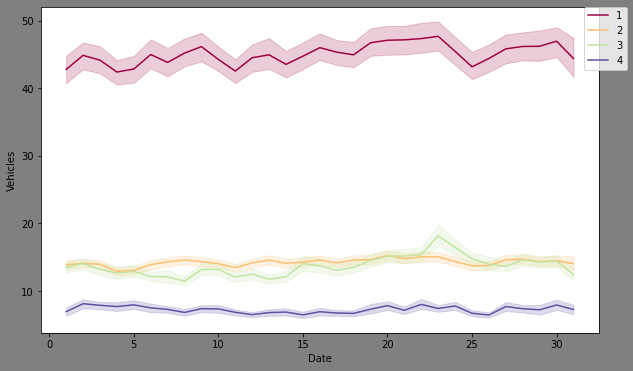

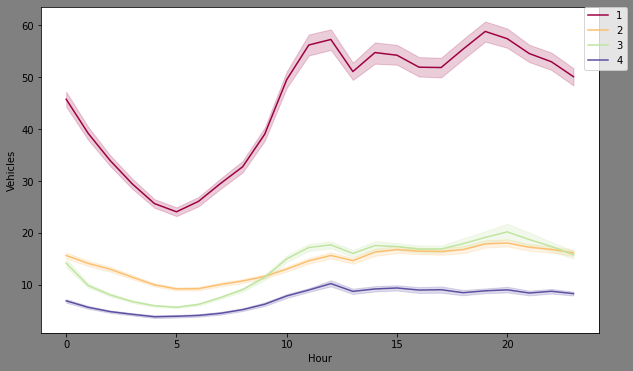

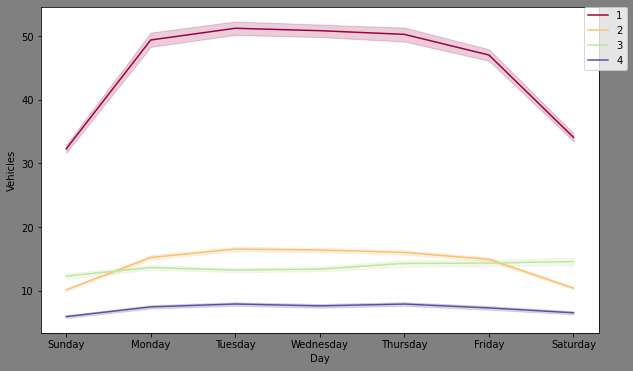

In [ ]:
"""
In this section:
Perform Exploratory Data Analysis of the new engineered features
"""
n_features = ['Year', 'Month', 'Date', 'Hour', 'Day']

for i in n_features:
    plt.figure(figsize=(10,6), facecolor="#808080")
    ax = sns.lineplot(x=data[i], y='Vehicles', data=data, hue='Junction', palette='Spectral')
    
    plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)

Text(0.5, 0, 'Date')

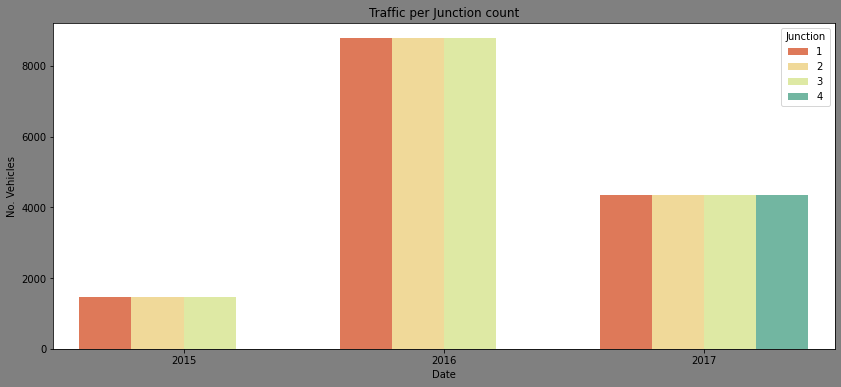

In [ ]:
plt.figure(figsize=(14, 6), facecolor='#808080')

count = sns.countplot(data=data, x=data['Year'], hue='Junction', palette='Spectral')

count.set_title('Traffic per Junction count')
count.set_ylabel('No. Vehicles')
count.set_xlabel('Date')

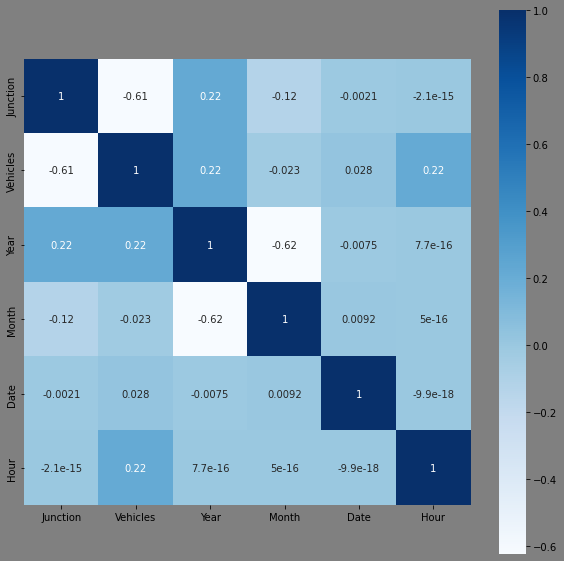

In [ ]:
corrmat = data.corr()

plt.subplots(figsize=(10,10), facecolor='#808080')
sns.heatmap(corrmat, cmap='Blues', annot=True, square=True)

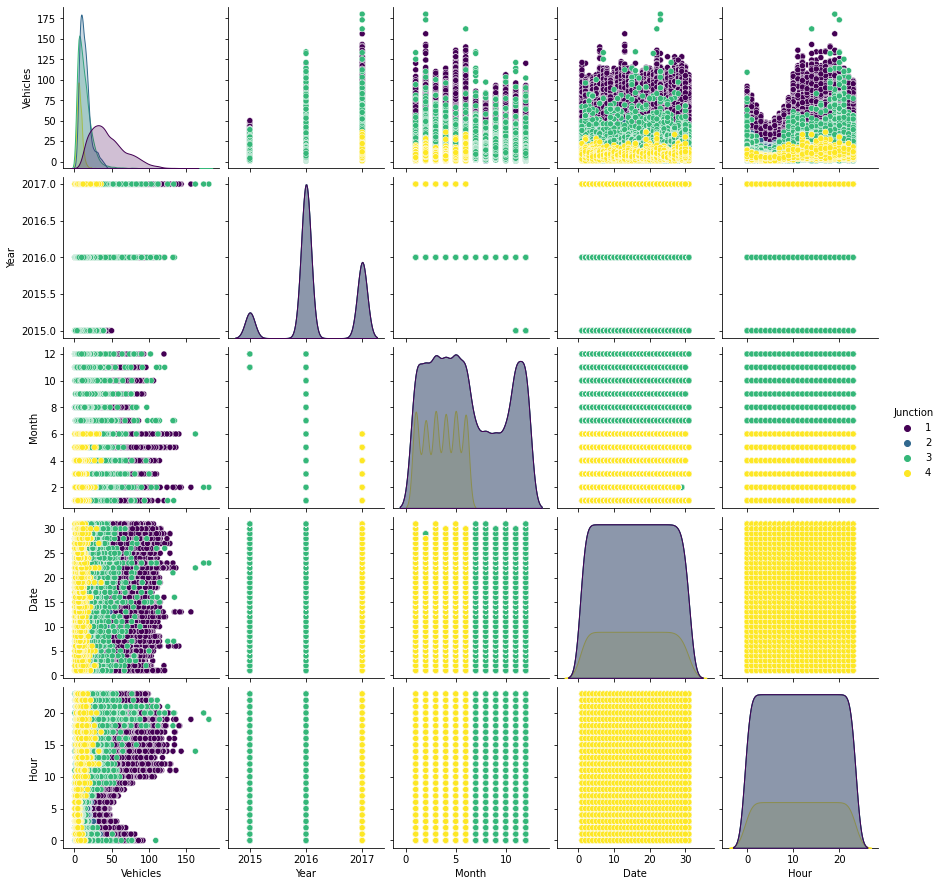

In [ ]:
sns.pairplot(data=data, hue='Junction', palette='viridis')

In [ ]:
df

,DateTime,Junction,Vehicles
0,2015-11-01 00:00:00,1,15
1,2015-11-01 01:00:00,1,13
2,2015-11-01 02:00:00,1,10
3,2015-11-01 03:00:00,1,7
4,2015-11-01 04:00:00,1,9
...,...,...,...
48115,2017-06-30 19:00:00,4,11
48116,2017-06-30 20:00:00,4,30
48117,2017-06-30 21:00:00,4,16
48118,2017-06-30 22:00:00,4,22


In [ ]:
"""
In this section:
Pivot data on the Junction column, and check distribution of cars on each junction
"""
df_j = df.pivot(columns='Junction', index="DateTime")

df_j.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

In [ ]:
"""
In this section:
create new data columns for each junction in the dataset based on the number of vehicles
"""
df_1 = df_j[[('Vehicles', 1)]]
df_2 = df_j[[('Vehicles', 2)]]
df_3 = df_j[[('Vehicles', 3)]]
df_4 = df_j[[('Vehicles', 4)]]

df_4 = df_4.dropna()

In [ ]:
"""
In this section:
Check how the number of vehicles is distributed on each junction over time - A time series analysis
"""
list_df = [df_1, df_2, df_3, df_4]

for i in list_df:
    i.columns = i.columns.droplevel(level=1)

    def sub_plots_4(df_1, df_2, df_3, df_4, title):
        fig, axes = plt.subplots(4, 1, figsize=(15, 8), facecolor="#808080", sharey=True)
        fig.suptitle(title)

        plot_1 = sns.lineplot(ax=axes[0], data=df_1, color='blue')
        axes[0].set(ylabel = 'Junction 1')

        plot_2 = sns.lineplot(ax=axes[1], data=df_2, color='red')
        axes[1].set(ylabel='Junction 2')

        plot_3 = sns.lineplot(ax=axes[2], data=df_3, color='purple')
        axes[2].set(ylabel='Junction 3')

        plot_4 = sns.lineplot(ax=axes[3], data=df_4, color='green')
        axes[3].set(ylabel = 'Junction 4')

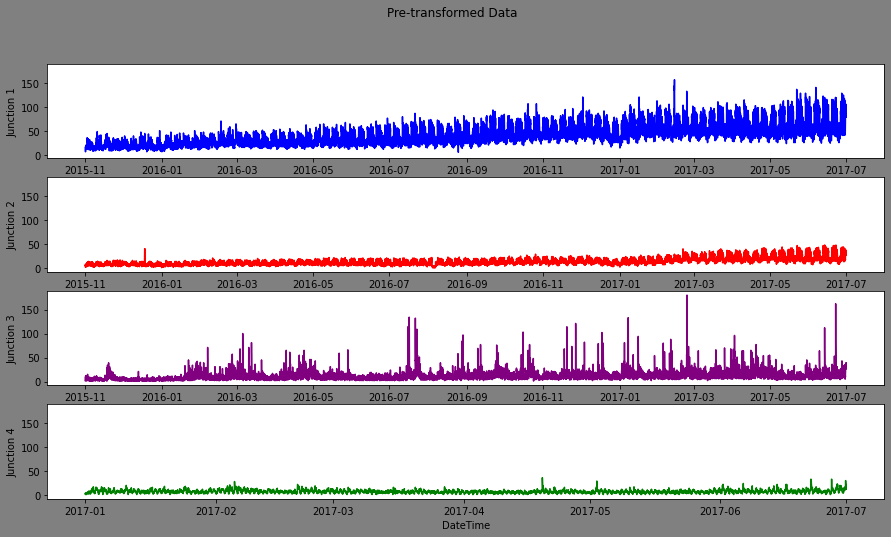

In [ ]:
sub_plots_4(df_1.Vehicles, df_2.Vehicles, df_3.Vehicles, df_4.Vehicles, 'Pre-transformed Data')

In [ ]:
"""
In this section:
Normalization:
Normalizing Time series data; to make the data stationery
 - Un-stationery time series data is data that does not follow a trend; normalization eliminates 'noise' data points
"""

def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()

    return df_normalized, average, stdev


In [ ]:
"""
In this section:
Differencing:
Differencing Time series data; to make the data stationery
 - Un-stationery time series data is data that does not follow a trend; differencing eliminates 'noise' data points
"""
def Difference(df,col, interval):
    return [df[col][i] - df[col][i - interval] for i in range(interval, len(df))]

In [ ]:
#Normalizing and Differencing to make the series stationary 
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) 
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

In [ ]:
df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) 
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

In [ ]:
df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) 
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

In [ ]:
df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) 
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

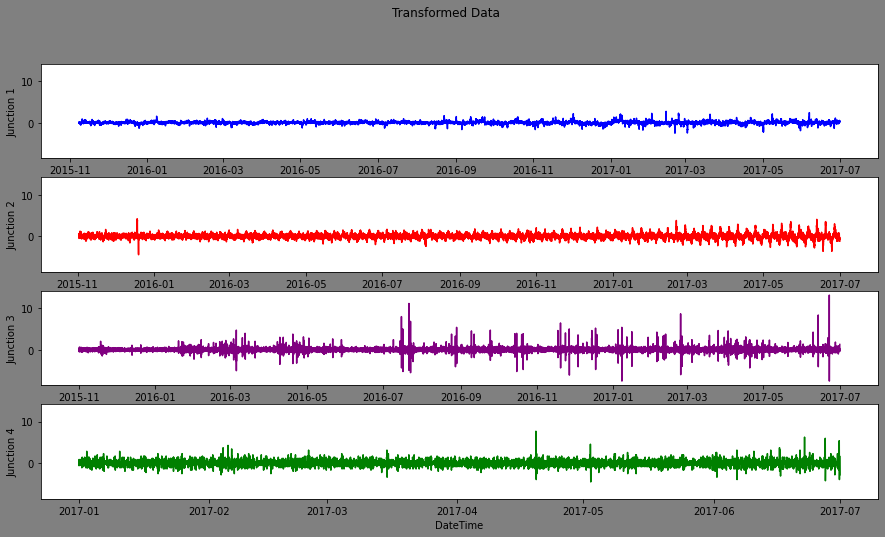

In [ ]:
"""
In this section:
Visualizing the transformed time series data.
"""
sub_plots_4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Transformed Data")

In [ ]:
#Stationary Check for the time series Augmented Dickey Fuller test
"""
In this section:
Check to see if the transformed (normalized & differenced data) is stationery or non-stationery
 - An output of stationery implies perfectly transformed time series data.
 -The technique employed is the Augmented Dickey Fuller test from statsmodel library
"""
def Stationary_check(df):
    check = adfuller(df.dropna())

    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")

    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Non-Stationary")
    else:
        print("Stationary") 

#Checking if the series is stationary
List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]] 
print("stationarity check:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

stationarity check:


ADF Statistic: -15.265303390415573
p-value: 4.798539876394827e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


ADF Statistic: -21.795891026940076
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


ADF Statistic: -28.00175990883259
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


ADF Statistic: -17.979092563052358
p-value: 2.7787875325952613e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Stationary


In [ ]:
"""
In this section:
Delete non-numerical values in df_4 (the dataframe for Junction 4 which has missing values as seen from EDA)
"""
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

In [ ]:
"""
In this section:
Splitting the dataset
"""
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[:training_size], df[training_size:data_len]
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test

In [ ]:
"""
In this section:
Spliting the training and test datasets
"""
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

In [ ]:
"""
In this section:
Specifying the independent and dependent variables
"""
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

In [ ]:
#fixing the shape of X_test and X_train
"""
In this section:
Transforming the shape of the training and test data to a numerically feasible range
"""
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

In [ ]:
"""
In this section:
Assigining features & targets
"""
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

In [ ]:
"""
In this section:
Specifying visualization colors
"""
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]

In [ ]:
"""
In this section:
Defining the GRU Deep Learning model
"""
def GRU_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True) 

    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    
    #model.add(GRU(units=50, return_sequences=True,  input_shape=(X_Train.shape[1],1),activation='tanh'))
    #model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    #Compiling the model
    model.compile(optimizer=SGD(decay=1e-7, momentum=0.9),loss='mean_squared_error')

    model.fit(X_Train,y_Train, epochs=20, batch_size=100, callbacks=[early_stopping])

    pred_GRU= model.predict(X_Test)

    return pred_GRU


In [ ]:
"""
In this section:
Calculating the Root Mean Squared Error (RMSE) score from the predictions
"""
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

In [ ]:
"""
In this section:
Visualization of the targets values and the predicted values
"""
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#627D78")
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("GRU Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

In [ ]:
"""
In this section:
Fitting the model: Junction 1
Fitting the model: The model is fitted separately for each of the four junctions
"""
PredJ1 = GRU_model(X_trainJ1,y_trainJ1,X_testJ1)

Epoch 1/20
130/130 [==============================] - ETA: 0s - loss: 0.0724

130/130 [==============================] - 52s 325ms/step - loss: 0.0724
Epoch 2/20
130/130 [==============================] - ETA: 0s - loss: 0.0649

130/130 [==============================] - 41s 316ms/step - loss: 0.0649
Epoch 3/20
130/130 [==============================] - ETA: 0s - loss: 0.0630

130/130 [==============================] - 41s 313ms/step - loss: 0.0630
Epoch 4/20
130/130 [==============================] - ETA: 0s - loss: 0.0615

130/130 [==============================] - 41s 318ms/step - loss: 0.0615
Epoch 5/20
130/130 [==============================] - ETA: 0s - loss: 0.0603

130/130 [==============================] - 41s 315ms/step - loss: 0.0603
Epoch 6/20
130/130 [==============================] - ETA: 0s - loss: 0.0583

130/130 [==============================] - 41s 316ms/step - loss: 0.0583
Epoch 7/20
130/130 [==============================] - ETA: 0s - loss: 0.0577

130/130 [==============================] - 42s 321ms/step - loss: 0.0577
Epoch 8/20
130/130 [==============================] - ETA: 0s - loss: 0.0566

130/130 [==============================] - 42s 321ms/step - loss: 0.0566
Epoch 9/20
130/130 [==============================] - ETA: 0s - loss: 0.0557

130/130 [==============================] - 42s 326ms/step - loss: 0.0557
Epoch 10/20
130/130 [==============================] - ETA: 0s - loss: 0.0552

130/130 [==============================] - 42s 321ms/step - loss: 0.0552
Epoch 11/20
130/130 [==============================] - ETA: 0s - loss: 0.0538

130/130 [==============================] - 42s 320ms/step - loss: 0.0538
Epoch 12/20
130/130 [==============================] - ETA: 0s - loss: 0.0536

130/130 [==============================] - 41s 312ms/step - loss: 0.0536
Epoch 13/20
130/130 [==============================] - ETA: 0s - loss: 0.0530

130/130 [==============================] - 40s 308ms/step - loss: 0.0530
Epoch 14/20
130/130 [==============================] - ETA: 0s - loss: 0.0523

130/130 [==============================] - 40s 310ms/step - loss: 0.0523
Epoch 15/20
130/130 [==============================] - ETA: 0s - loss: 0.0522

130/130 [==============================] - 40s 309ms/step - loss: 0.0522
Epoch 16/20
130/130 [==============================] - ETA: 0s - loss: 0.0513

130/130 [==============================] - 41s 312ms/step - loss: 0.0513
Epoch 17/20
130/130 [==============================] - ETA: 0s - loss: 0.0509

130/130 [==============================] - 41s 314ms/step - loss: 0.0509
Epoch 18/20
130/130 [==============================] - ETA: 0s - loss: 0.0502

130/130 [==============================] - 41s 316ms/step - loss: 0.0502
Epoch 19/20
130/130 [==============================] - ETA: 0s - loss: 0.0503

130/130 [==============================] - 41s 315ms/step - loss: 0.0503
Epoch 20/20
130/130 [==============================] - ETA: 0s - loss: 0.0501

45/45 [==============================] - 5s 49ms/step


The root mean squared error is 0.24997926616026067.


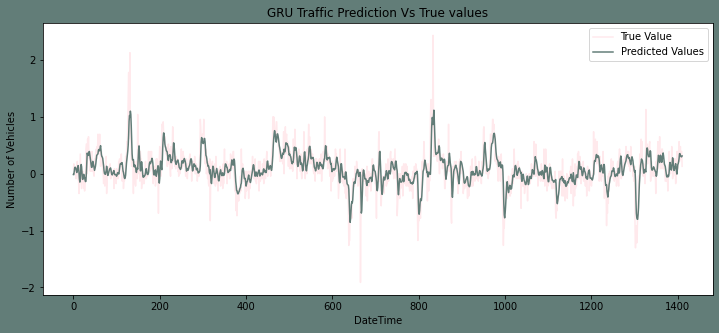

In [ ]:
"""
In this section:
Model score: JUnction 1
"""
RMSE_J1=RMSE_Value(y_testJ1,PredJ1)
PredictionsPlot(y_testJ1, PredJ1, 0)

In [ ]:
"""
In this section:
Fitting the model: Junction 2
"""
PredJ2 = GRU_model(X_trainJ2,y_trainJ2,X_testJ2)

Epoch 1/20
131/131 [==============================] - ETA: 0s - loss: 0.2238

131/131 [==============================] - 51s 313ms/step - loss: 0.2238
Epoch 2/20
131/131 [==============================] - ETA: 0s - loss: 0.2007

131/131 [==============================] - 41s 312ms/step - loss: 0.2007
Epoch 3/20
131/131 [==============================] - ETA: 0s - loss: 0.1962

131/131 [==============================] - 41s 312ms/step - loss: 0.1962
Epoch 4/20
131/131 [==============================] - ETA: 0s - loss: 0.1921

131/131 [==============================] - 41s 312ms/step - loss: 0.1921
Epoch 5/20
131/131 [==============================] - ETA: 0s - loss: 0.1898

131/131 [==============================] - 41s 312ms/step - loss: 0.1898
Epoch 6/20
131/131 [==============================] - ETA: 0s - loss: 0.1900

131/131 [==============================] - 41s 312ms/step - loss: 0.1900
Epoch 7/20
131/131 [==============================] - ETA: 0s - loss: 0.1896

131/131 [==============================] - 41s 315ms/step - loss: 0.1896
Epoch 8/20
131/131 [==============================] - ETA: 0s - loss: 0.1901

131/131 [==============================] - 41s 314ms/step - loss: 0.1901
Epoch 9/20
131/131 [==============================] - ETA: 0s - loss: 0.1871

131/131 [==============================] - 41s 317ms/step - loss: 0.1871
Epoch 10/20
131/131 [==============================] - ETA: 0s - loss: 0.1876

131/131 [==============================] - 41s 309ms/step - loss: 0.1876
Epoch 11/20
131/131 [==============================] - ETA: 0s - loss: 0.1890

131/131 [==============================] - 40s 309ms/step - loss: 0.1890
Epoch 12/20
131/131 [==============================] - ETA: 0s - loss: 0.1870

131/131 [==============================] - 41s 310ms/step - loss: 0.1870
Epoch 13/20
131/131 [==============================] - ETA: 0s - loss: 0.1866

131/131 [==============================] - 40s 306ms/step - loss: 0.1866
Epoch 14/20
131/131 [==============================] - ETA: 0s - loss: 0.1865

131/131 [==============================] - 40s 309ms/step - loss: 0.1865
Epoch 15/20
131/131 [==============================] - ETA: 0s - loss: 0.1856

131/131 [==============================] - 41s 312ms/step - loss: 0.1856
Epoch 16/20
131/131 [==============================] - ETA: 0s - loss: 0.1856

131/131 [==============================] - 41s 310ms/step - loss: 0.1856
Epoch 17/20
131/131 [==============================] - ETA: 0s - loss: 0.1855

131/131 [==============================] - 41s 311ms/step - loss: 0.1855
Epoch 18/20
131/131 [==============================] - ETA: 0s - loss: 0.1854

131/131 [==============================] - 41s 309ms/step - loss: 0.1854
Epoch 19/20
131/131 [==============================] - ETA: 0s - loss: 0.1849

131/131 [==============================] - 41s 311ms/step - loss: 0.1849
Epoch 20/20
131/131 [==============================] - ETA: 0s - loss: 0.1846

45/45 [==============================] - 4s 48ms/step


The root mean squared error is 0.5693934752177314.


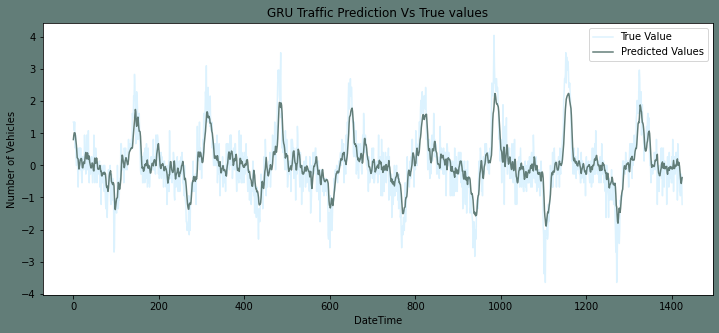

In [ ]:
"""
In this section:
Model score: Junction 2
"""
RMSE_J2=RMSE_Value(y_testJ2,PredJ2)
PredictionsPlot(y_testJ2,PredJ2,1)

In [114]:
"""
In this section:
Fitting the model: Junction 3
"""
PredJ3 = GRU_model(X_trainJ3,y_trainJ3,X_testJ3) 

Epoch 1/20
131/131 [==============================] - ETA: 0s - loss: 0.3018

131/131 [==============================] - 53s 318ms/step - loss: 0.3018
Epoch 2/20
131/131 [==============================] - ETA: 0s - loss: 0.2946

131/131 [==============================] - 42s 318ms/step - loss: 0.2946
Epoch 3/20
131/131 [==============================] - ETA: 0s - loss: 0.2920

131/131 [==============================] - 42s 320ms/step - loss: 0.2920
Epoch 4/20
131/131 [==============================] - ETA: 0s - loss: 0.2927

131/131 [==============================] - 42s 318ms/step - loss: 0.2927
Epoch 5/20
131/131 [==============================] - ETA: 0s - loss: 0.2905

131/131 [==============================] - 41s 315ms/step - loss: 0.2905
Epoch 6/20
131/131 [==============================] - ETA: 0s - loss: 0.2903

131/131 [==============================] - 42s 318ms/step - loss: 0.2903
Epoch 7/20
131/131 [==============================] - ETA: 0s - loss: 0.2879

131/131 [==============================] - 41s 316ms/step - loss: 0.2879
Epoch 8/20
131/131 [==============================] - ETA: 0s - loss: 0.2884

131/131 [==============================] - 41s 309ms/step - loss: 0.2884
Epoch 9/20
131/131 [==============================] - ETA: 0s - loss: 0.2854

131/131 [==============================] - 39s 298ms/step - loss: 0.2854
Epoch 10/20
131/131 [==============================] - ETA: 0s - loss: 0.2831

131/131 [==============================] - 42s 319ms/step - loss: 0.2831
Epoch 11/20
131/131 [==============================] - ETA: 0s - loss: 0.2852

131/131 [==============================] - 42s 318ms/step - loss: 0.2852
Epoch 12/20
131/131 [==============================] - ETA: 0s - loss: 0.2832

131/131 [==============================] - 42s 322ms/step - loss: 0.2832
Epoch 13/20
131/131 [==============================] - ETA: 0s - loss: 0.2853

131/131 [==============================] - 42s 322ms/step - loss: 0.2853
Epoch 14/20
131/131 [==============================] - ETA: 0s - loss: 0.2819

131/131 [==============================] - 42s 321ms/step - loss: 0.2819
Epoch 15/20
131/131 [==============================] - ETA: 0s - loss: 0.2815

131/131 [==============================] - 42s 319ms/step - loss: 0.2815
Epoch 16/20
131/131 [==============================] - ETA: 0s - loss: 0.2808

131/131 [==============================] - 42s 319ms/step - loss: 0.2808
Epoch 17/20
131/131 [==============================] - ETA: 0s - loss: 0.2770

131/131 [==============================] - 42s 321ms/step - loss: 0.2770
Epoch 18/20
131/131 [==============================] - ETA: 0s - loss: 0.2728

131/131 [==============================] - 41s 316ms/step - loss: 0.2728
Epoch 19/20
131/131 [==============================] - ETA: 0s - loss: 0.2754

131/131 [==============================] - 41s 312ms/step - loss: 0.2754
Epoch 20/20
131/131 [==============================] - ETA: 0s - loss: 0.2733

45/45 [==============================] - 4s 50ms/step


The root mean squared error is 0.6109334397662559.


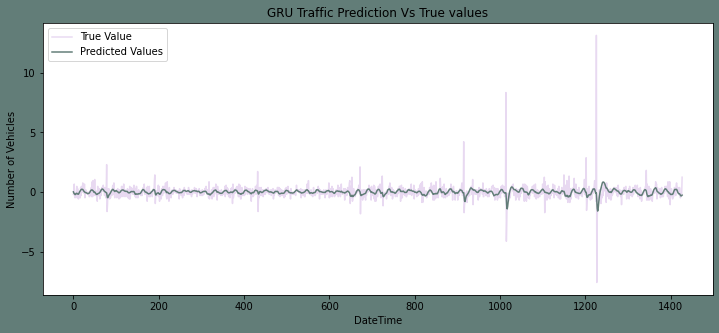

In [115]:
"""
In this section:
Model score: Junction 3
"""
RMSE_J3=RMSE_Value(y_testJ3,PredJ3)
PredictionsPlot(y_testJ3,PredJ3,2)

In [116]:
"""
In this section:
Fitting the model: Junction 4
"""
PredJ4 = GRU_model(X_trainJ4,y_trainJ4,X_testJ4)

Epoch 1/20
39/39 [==============================] - ETA: 0s - loss: 0.6914

39/39 [==============================] - 21s 293ms/step - loss: 0.6914
Epoch 2/20
39/39 [==============================] - ETA: 0s - loss: 0.6877

39/39 [==============================] - 12s 317ms/step - loss: 0.6877
Epoch 3/20
39/39 [==============================] - ETA: 0s - loss: 0.6875

39/39 [==============================] - 12s 316ms/step - loss: 0.6875
Epoch 4/20
39/39 [==============================] - ETA: 0s - loss: 0.6902

39/39 [==============================] - 12s 312ms/step - loss: 0.6902
Epoch 5/20
39/39 [==============================] - ETA: 0s - loss: 0.6840

39/39 [==============================] - 12s 313ms/step - loss: 0.6840
Epoch 6/20
39/39 [==============================] - ETA: 0s - loss: 0.6822

39/39 [==============================] - 12s 318ms/step - loss: 0.6822
Epoch 7/20
39/39 [==============================] - ETA: 0s - loss: 0.6838

39/39 [==============================] - 14s 370ms/step - loss: 0.6838
Epoch 8/20
39/39 [==============================] - ETA: 0s - loss: 0.6797

39/39 [==============================] - 12s 311ms/step - loss: 0.6797
Epoch 9/20
39/39 [==============================] - ETA: 0s - loss: 0.6914

39/39 [==============================] - 12s 307ms/step - loss: 0.6914
Epoch 10/20
39/39 [==============================] - ETA: 0s - loss: 0.6786

39/39 [==============================] - 12s 298ms/step - loss: 0.6786
Epoch 11/20
39/39 [==============================] - ETA: 0s - loss: 0.6776

39/39 [==============================] - 12s 306ms/step - loss: 0.6776
Epoch 12/20
39/39 [==============================] - ETA: 0s - loss: 0.6833

39/39 [==============================] - 12s 301ms/step - loss: 0.6833
Epoch 13/20
39/39 [==============================] - ETA: 0s - loss: 0.6775

39/39 [==============================] - 12s 307ms/step - loss: 0.6775
Epoch 14/20
39/39 [==============================] - ETA: 0s - loss: 0.6804

39/39 [==============================] - 12s 308ms/step - loss: 0.6804
Epoch 15/20
39/39 [==============================] - ETA: 0s - loss: 0.6761

39/39 [==============================] - 12s 309ms/step - loss: 0.6761
Epoch 16/20
39/39 [==============================] - ETA: 0s - loss: 0.6739

39/39 [==============================] - 12s 311ms/step - loss: 0.6739
Epoch 17/20
39/39 [==============================] - ETA: 0s - loss: 0.6734

39/39 [==============================] - 12s 308ms/step - loss: 0.6734
Epoch 18/20
39/39 [==============================] - ETA: 0s - loss: 0.6760

39/39 [==============================] - 12s 309ms/step - loss: 0.6760
Epoch 19/20
39/39 [==============================] - ETA: 0s - loss: 0.6749

39/39 [==============================] - 12s 308ms/step - loss: 0.6749
Epoch 20/20
39/39 [==============================] - ETA: 0s - loss: 0.6701

13/13 [==============================] - 2s 49ms/step


The root mean squared error is 1.0965249370810042.


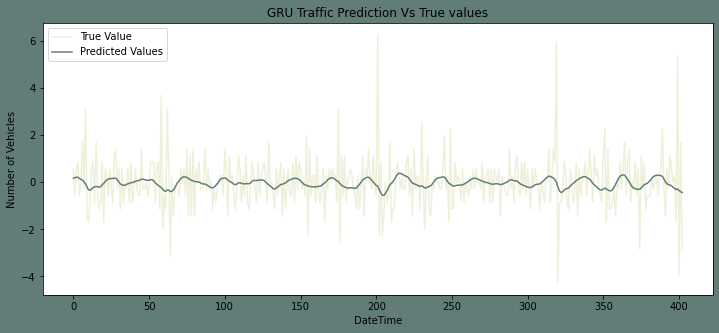

In [117]:
"""
In this section:
Model score: Junction 4
"""
RMSE_J4=RMSE_Value(y_testJ4,PredJ4)
PredictionsPlot(y_testJ4,PredJ4,3)

In [118]:
"""
In this section:
Perform inverse transform to compare model performance on known and unknown data
"""
def inverse_difference(last_ob, value):
    return value + last_ob

In [119]:
"""
In this section:
Visualizing the compared performance from the inverse transformation
"""
def Sub_Plots2(df_1, df_2,title,m):
    fig, axes = plt.subplots(1, 2, figsize=(18,4), sharey=True,facecolor="#627D78")
    fig.suptitle(title)
    
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[m])
    axes[0].set(ylabel ="Prediction")
    
    pl_2=sns.lineplot(ax=axes[1],data=df_2["Vehicles"],color="#627D78")
    axes[1].set(ylabel ="Orignal")

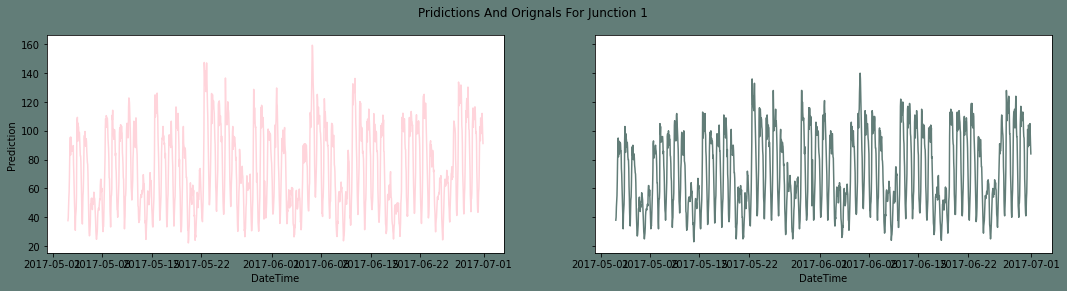

In [120]:
"""
In this section:
Fit the inverse tranformation and comparison on Junction 1 and visualize the comparison plot
"""
recover1 = df_N1.Norm[-1412:-1].to_frame()
recover1["Pred"]= PredJ1

Transform_reverssed_J1 = inverse_difference(recover1.Norm, recover1.Pred).to_frame()
Transform_reverssed_J1.columns = ["Pred_Normed"]

Final_J1_Pred = (Transform_reverssed_J1.values* std_J1) + av_J1
Transform_reverssed_J1["Pred_Final"] =Final_J1_Pred

Sub_Plots2(Transform_reverssed_J1["Pred_Final"], df_1[-1412:-1],"Pridictions And Orignals For Junction 1", 0)

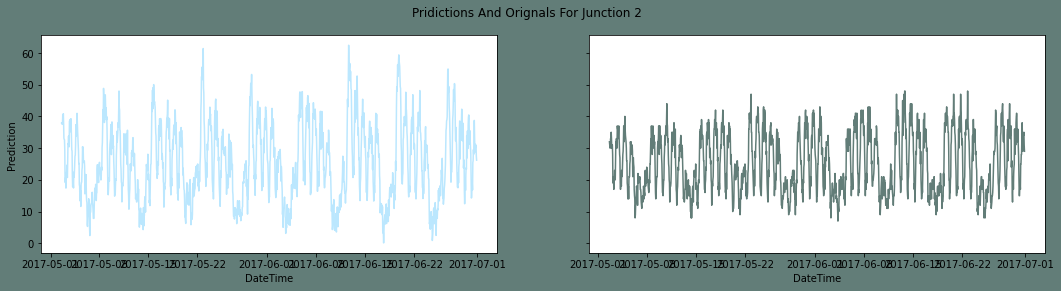

In [121]:
"""
In this section:
Fit the inverse tranformation and comparison on Junction 2 and visualize the comparison plot
"""
recover2 = df_N2.Norm[-1426:-1].to_frame() 
recover2["Pred"]= PredJ2

Transform_reverssed_J2 = inverse_difference(recover2.Norm, recover2.Pred).to_frame()
Transform_reverssed_J2.columns = ["Pred_Normed"]
Final_J2_Pred = (Transform_reverssed_J2.values* std_J2) + av_J2
Transform_reverssed_J2["Pred_Final"] =Final_J2_Pred

Sub_Plots2(Transform_reverssed_J2["Pred_Final"], df_2[-1426:-1],"Pridictions And Orignals For Junction 2", 1)

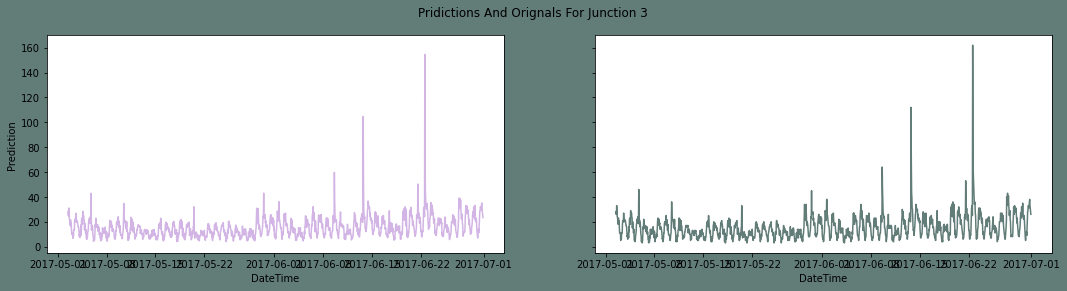

In [122]:
"""
In this section:
Fit the inverse tranformation and comparison on Junction 3, and visualize the comparison plot
"""
recover3 = df_N3.Norm[-1429:-1].to_frame()
recover3["Pred"]= PredJ3
Transform_reverssed_J3 = inverse_difference(recover3.Norm, recover3.Pred).to_frame()
Transform_reverssed_J3.columns = ["Pred_Normed"]

Final_J3_Pred = (Transform_reverssed_J3.values* std_J3) + av_J3
Transform_reverssed_J3["Pred_Final"] =Final_J3_Pred
Sub_Plots2(Transform_reverssed_J3["Pred_Final"], df_3[-1429:-1],"Pridictions And Orignals For Junction 3", 2)

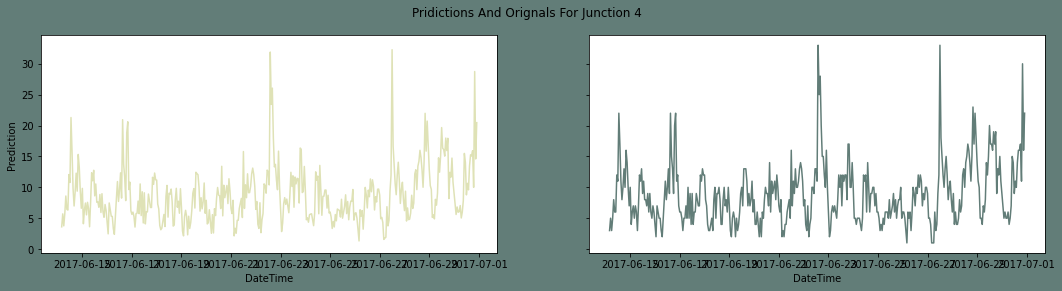

In [123]:
"""
In this section:
Fit the inverse tranformation and comparison on Junction 4 and visualize the comparison plot
"""
recover4 = df_N4.Norm[-404:-1].to_frame()  
recover4["Pred"]= PredJ4
Transform_reverssed_J4 = inverse_difference(recover4.Norm, recover4.Pred).to_frame()
Transform_reverssed_J4.columns = ["Pred_Normed"]

Final_J4_Pred = (Transform_reverssed_J4.values* std_J4) + av_J4
Transform_reverssed_J4["Pred_Final"] =Final_J4_Pred
Sub_Plots2(Transform_reverssed_J4["Pred_Final"], df_4[-404:-1],"Pridictions And Orignals For Junction 4", 3)

#### Model Performance

##### Junction                         RMSE Score
##### 1         ==>                           0.249
##### 2            ==>                        0.569
##### 3              ==>                      0.611
##### 4                 ==>                   1.096

The RMSE score on Junction 4, can be attributed to the high number of missing values [or the infrequency of motor usage
on the junction over long periods of time]

From the score on Junctions 1 - 3, the RMSE score implies a high level of confidence in the applications ability to predict 
from on the three different locations.

The models performance can be improved by increasing the epoch and batch size values for the GNU model. 